In [1]:
%load_ext autoreload
%autoreload 2

# Exploratory Analysis

## Spotify

In [2]:
import os
import json

import numpy as np
import pandas as pd
import tidybear as tb

import matplotlib.pyplot as plt
from plotnine import *

%matplotlib inline

In [82]:
disco = pd.read_csv("../data/Spotify.csv")
disco["released"] = pd.to_datetime(disco.released)

disco = disco.loc[~disco.name.str.contains("- Live"), :]
disco.loc[disco.album_name.str.contains("One By One"), "album_name"] = "One By One"


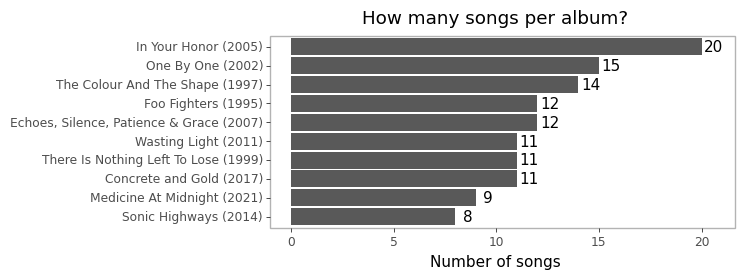

<ggplot: (8758366329532)>

In [83]:
data = disco.copy()

get_display_name = lambda x: f"{x.album_name} ({x.released.year})"
data["display_name"] = data.apply(get_display_name, axis=1)

(
    ggplot(aes("reorder(display_name, n)", "n"), tb.count(data, "display_name"))
    + geom_col()
    + coord_flip()
    + geom_text(aes(label="n"), nudge_y=0.6)
    + labs(title="How many songs per album?", x=None, y="Number of songs")
    + theme_light()
    + theme(panel_grid=element_blank(), figure_size=(6, 2.5))
)


In [84]:
data = disco.copy()

data["display_name"] = data.apply(get_display_name, axis=1)
data["release_year"] = data.released.dt.year

data = (
    data[["display_name", "name", "release_year"] + data.columns[5:-2].tolist()]
    .drop(columns=["time_signature", "key", "mode"])
    .set_index(["display_name", "release_year", "name"])
    .stack()
    .reset_index()
)

data = tb.rename(data, "album", "year", "song", "metric", "value")
data = (
    data.groupby(["album", "year", "metric"])
    .value.mean()
    .rename("mean_value")
    .reset_index()
)

/home/mbmackenzie/workspace/setlist-survival/venv/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


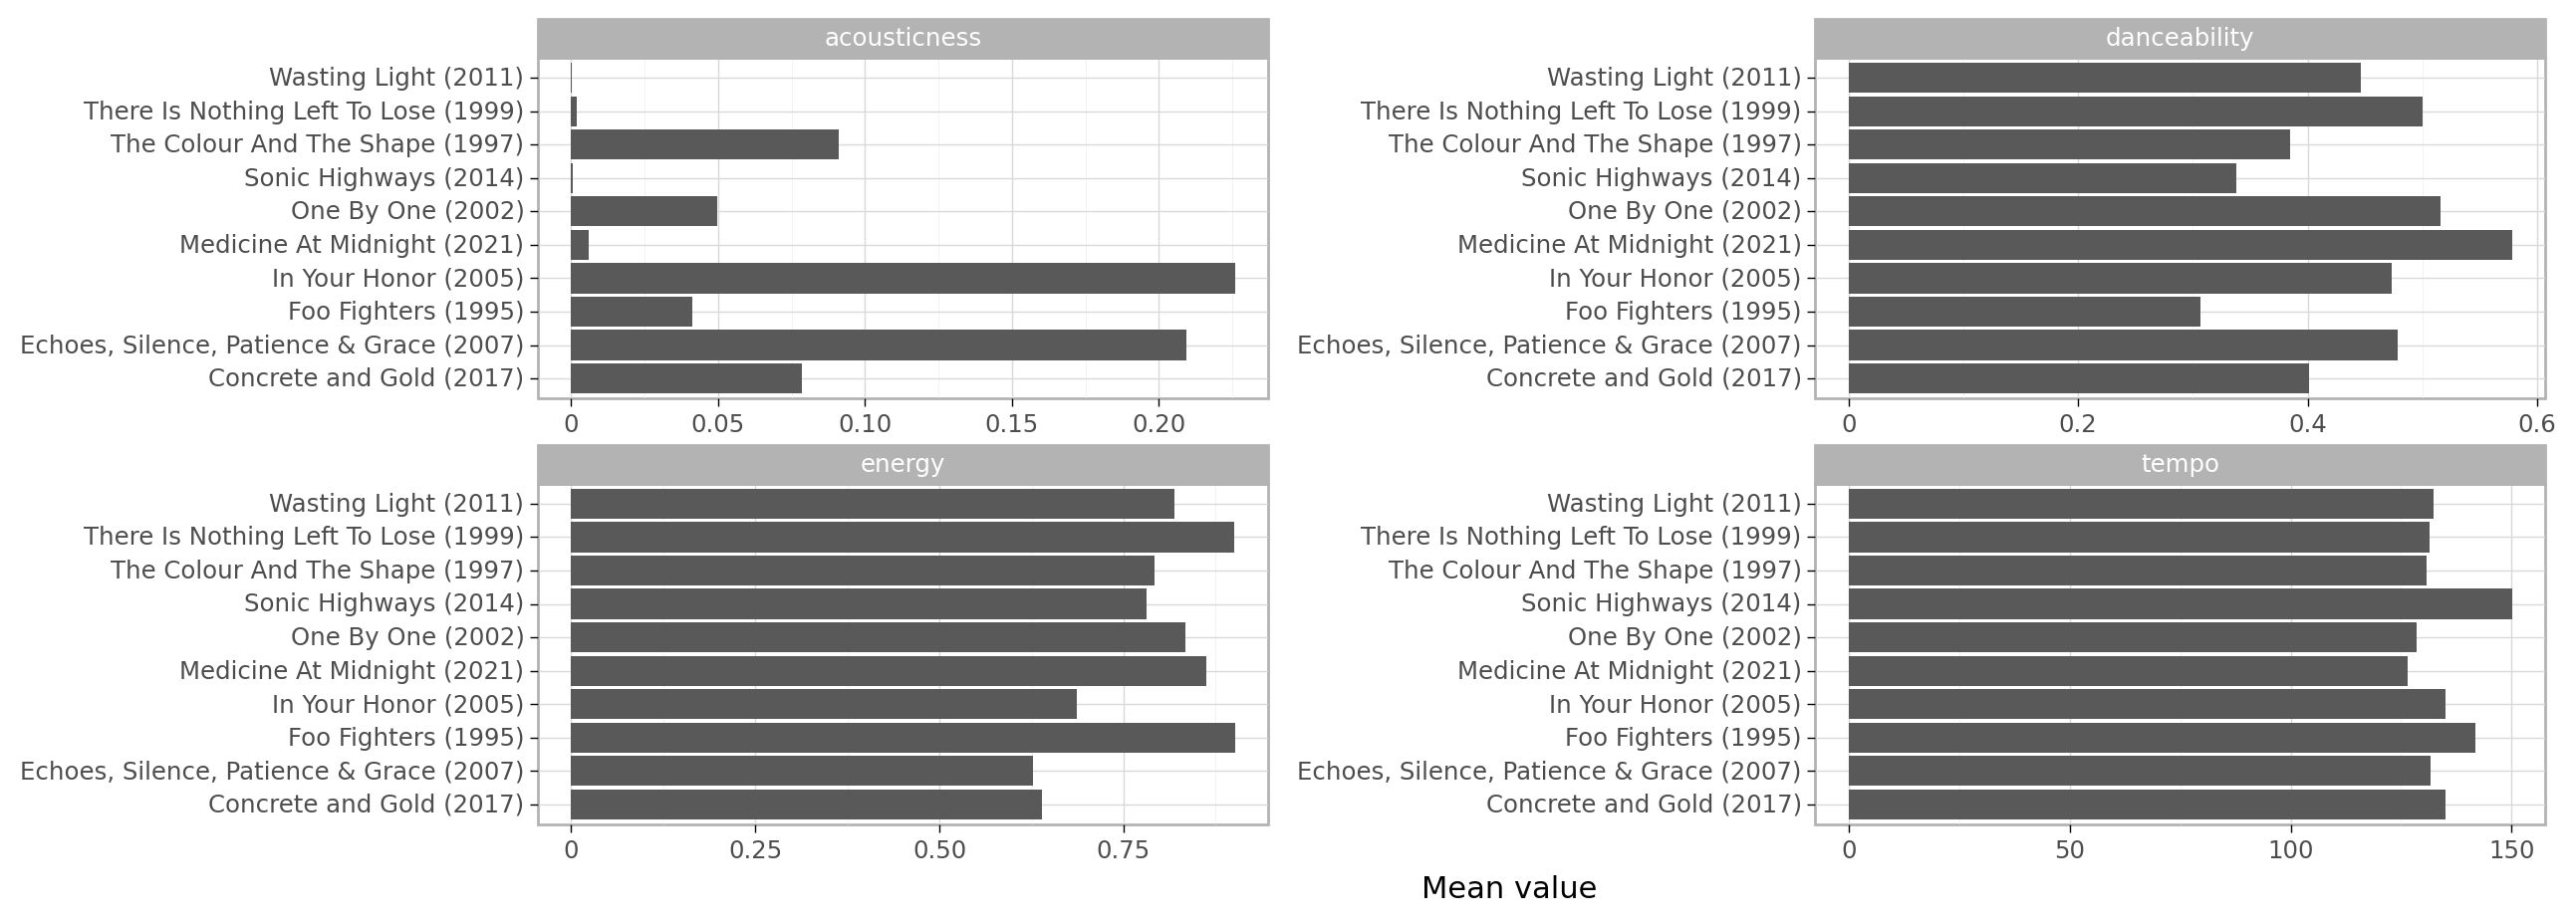

<ggplot: (8758359861137)>

In [85]:
plot_feats = ["danceability", "energy", "acousticness", "tempo"]

audio_features_tidy = data[data.metric.isin(plot_feats)].copy()
audio_features_tidy = audio_features_tidy.sort_values(["metric", "mean_value"])

(
    ggplot(aes("album", "mean_value"), audio_features_tidy)
    + geom_col()
    + coord_flip()
    + facet_wrap("metric", ncol=2, scales="free")
    + labs(x=None, y=f"Mean value")
    + theme_light()
    + theme(
        figure_size=(13, 5),
        dpi=200,
        subplots_adjust={"hspace": 0.25, "wspace": 0.75},
    )
)


/home/mbmackenzie/workspace/setlist-survival/venv/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/mbmackenzie/workspace/setlist-survival/venv/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


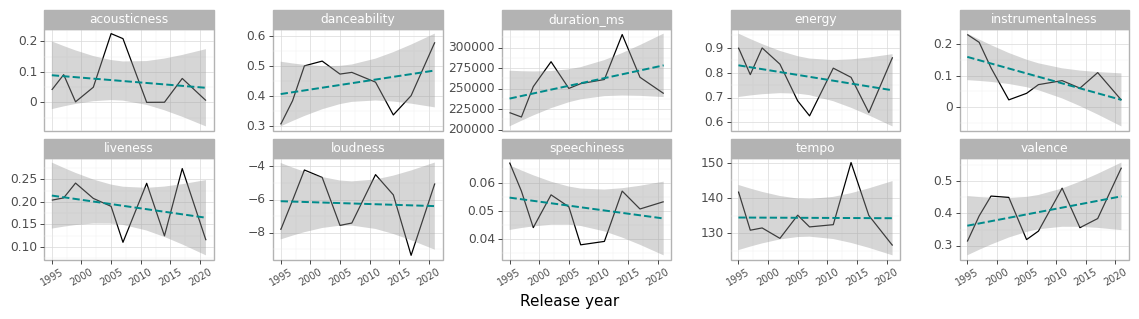

<ggplot: (8758360501029)>

In [86]:
audio_features_tidy = data.copy()

(
    ggplot(aes("year", "mean_value"), audio_features_tidy)
    + geom_line()
    + geom_smooth(
        method="lm",
        color="darkcyan",
        linetype="dashed",
        size=0.8,
    )
    + facet_wrap("metric", scales="free_y", nrow=2)
    + labs(y=None, x="Release year", color="Album")
    + theme_light()
    + theme(
        figure_size=(14, 3),
        subplots_adjust={"wspace": 0.35},
        axis_text_x=element_text(angle=30, size=7),
    )
)


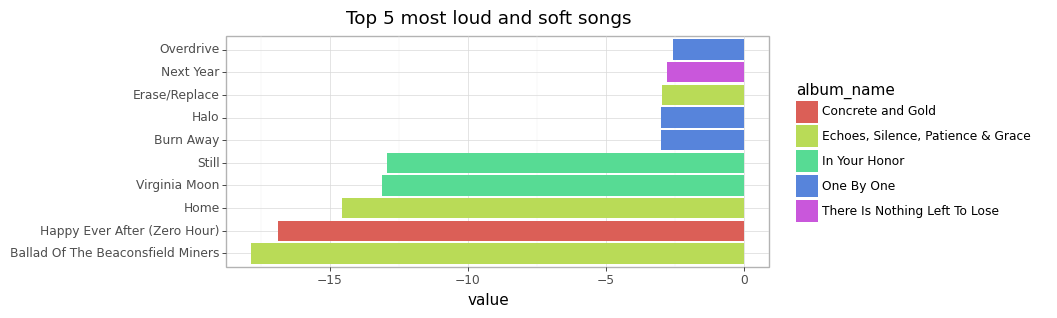

<ggplot: (8758366775366)>

In [87]:
loudness = disco[["album_name", "name", "loudness"]].copy()
loudness = pd.concat(
    [
        tb.top_n(loudness, order_by="loudness", n=5),
        tb.top_n(loudness, order_by="loudness", n=5, negate=True),
    ],
    axis=0,
)

(
    ggplot(
        aes(x="reorder(name, loudness)", y="loudness", fill="album_name"),
        loudness,
    )
    + geom_col()
    + coord_flip()
    + labs(x=None, y="value", title=f"Top 5 most loud and soft songs")
    + theme_light()
    + theme(figure_size=(7, 3))
)


---

## Setlist FM

In [135]:
concerts = pd.read_csv("../data/Setlist_Concerts.csv")
songs = pd.read_csv("../data/Setlist_Songs.csv")
venues = pd.read_csv("../data/Setlist_Venues.csv")


songs["num_songs"] = songs.groupby("concert_id").song_number.transform(max)
songs["set_position"] = (songs.song_number - 1) / songs.num_songs

setlists = (
    songs.loc[~songs.is_cover, :]
    .merge(concerts, left_on="concert_id", right_on="id")
    .merge(venues, left_on="venue_id", right_on="id")
    .loc[:, ["name_y", "country", "event_date", "set_position", "name_x"]]
)

setlists = tb.rename(
    setlists,
    "venue",
    "country",
    "event_date",
    "set_position",
    "fm_name",
)

setlists.dropna(inplace=True)
setlists["fm_name"] = setlists.fm_name.str.lower()
setlists = setlists.loc[setlists.fm_name.isin(disco.name.str.lower().unique())]

setlists


,venue,country,event_date,set_position,fm_name
0,Save Mart Center,US,2021-12-09,0.000000,times like these
1,Save Mart Center,US,2021-12-09,0.047619,the pretender
2,Save Mart Center,US,2021-12-09,0.095238,learn to fly
3,Save Mart Center,US,2021-12-09,0.142857,no son of mine
4,Save Mart Center,US,2021-12-09,0.190476,the sky is a neighborhood
...,...,...,...,...,...
19757,West Marine store,US,1995-02-19,0.500000,wattershed
19758,West Marine store,US,1995-02-19,0.583333,for all the cows
19759,West Marine store,US,1995-02-19,0.666667,good grief
19760,West Marine store,US,1995-02-19,0.750000,alone + easy target


In [136]:
final_data = setlists.merge(
    disco.assign(fm_name=lambda x: x.name.str.lower()), on="fm_name", how="right"
).drop("fm_name", axis=1)

final_data.to_csv("../data/Setlists with Spotify data.csv", index=False)

In [137]:
final_data

,venue,country,event_date,set_position,album_id,song_id,released,album_name,name,duration_ms,...,key,mode,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence
0,Dolby Live at Park MGM,US,2021-12-02,0.086957,1FyNZvJ6MHO01kl3ySMPdc,2u8NmvhYX6wiviyxJTOhEi,2021-02-05,Medicine At Midnight,Making A Fire,255107,...,9,1,0.506,0.946,-4.173,0.0652,0.000022,0.00226,0.0528,0.651
1,Hollywood Casino Amphitheatre,US,2021-08-03,0.714286,1FyNZvJ6MHO01kl3ySMPdc,2u8NmvhYX6wiviyxJTOhEi,2021-02-05,Medicine At Midnight,Making A Fire,255107,...,9,1,0.506,0.946,-4.173,0.0652,0.000022,0.00226,0.0528,0.651
2,American Family Insurance Amphitheater,US,2021-07-30,0.714286,1FyNZvJ6MHO01kl3ySMPdc,2u8NmvhYX6wiviyxJTOhEi,2021-02-05,Medicine At Midnight,Making A Fire,255107,...,9,1,0.506,0.946,-4.173,0.0652,0.000022,0.00226,0.0528,0.651
3,Madison Square Garden,US,2021-06-20,0.875000,1FyNZvJ6MHO01kl3ySMPdc,2u8NmvhYX6wiviyxJTOhEi,2021-02-05,Medicine At Midnight,Making A Fire,255107,...,9,1,0.506,0.946,-4.173,0.0652,0.000022,0.00226,0.0528,0.651
4,The Canyon,US,2021-06-15,0.913043,1FyNZvJ6MHO01kl3ySMPdc,2u8NmvhYX6wiviyxJTOhEi,2021-02-05,Medicine At Midnight,Making A Fire,255107,...,9,1,0.506,0.946,-4.173,0.0652,0.000022,0.00226,0.0528,0.651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18696,Mercury Theatre,US,1995-04-15,0.900000,4EnNuo8fG7dMoxMefbApRY,5EwyzrFLXlcnPenrPQ9DlO,1995-07-04,Foo Fighters,Exhausted,349893,...,7,1,0.192,0.977,-9.027,0.0932,0.001600,0.86700,0.2700,0.108
18697,Gibson's,US,1995-04-12,0.900000,4EnNuo8fG7dMoxMefbApRY,5EwyzrFLXlcnPenrPQ9DlO,1995-07-04,Foo Fighters,Exhausted,349893,...,7,1,0.192,0.977,-9.027,0.0932,0.001600,0.86700,0.2700,0.108
18698,Velvet Elvis,US,1995-03-04,0.900000,4EnNuo8fG7dMoxMefbApRY,5EwyzrFLXlcnPenrPQ9DlO,1995-07-04,Foo Fighters,Exhausted,349893,...,7,1,0.192,0.977,-9.027,0.0932,0.001600,0.86700,0.2700,0.108
18699,Satyricon,US,1995-03-03,0.818182,4EnNuo8fG7dMoxMefbApRY,5EwyzrFLXlcnPenrPQ9DlO,1995-07-04,Foo Fighters,Exhausted,349893,...,7,1,0.192,0.977,-9.027,0.0932,0.001600,0.86700,0.2700,0.108


In [143]:
with tb.GroupBy(final_data, ["album_name", "name"]) as g:
    g.n(name="num_performances")
    g.mean("set_position", name="mean_position", decimals=2)
    g.min("event_date", name="first_performed")
    g.max("event_date", name="last_performed")

    summary = g.summarise()

tb.top_n(summary, order_by="num_performances", n=10)


num_performances  \
album_name                    name                                 
The Colour And The Shape      Everlong                      1079   
                              Monkey Wrench                  990   
                              My Hero                        965   
Foo Fighters                  This Is a Call                 895   
There Is Nothing Left To Lose Learn to Fly                   885   
One By One                    Times Like These               769   
                              All My Life                    750   
There Is Nothing Left To Lose Breakout                       720   
In Your Honor                 Best of You                    624   
Foo Fighters                  Big Me                         611   

                                                mean_position first_performed  \
album_name                    name                                              
The Colour And The Shape      Everlong                   0.76      1997-05-20   
                              Monkey Wrench              0.52      1997-05-02   
                              My Hero                    0.31      1995-07-20   
Foo Fighters                  This Is a Call             0.59      1995-02-19   
There Is Nothing Left To Lose Learn to Fly               0.21      1999-09-03   
One By One                    Times Like These           0.40      2002-07-12   
                              All My Life                0.36      2002-02-07   
There Is Nothing Left To Lose Breakout                   0.42      1999-09-03   
In Your Honor                 Best of You                0.75      2005-04-28   
Foo Fighters                  Big Me                     0.49      1995-02-19   

                                               last_performed  
album_name                    name                             
The Colour And The Shape      Everlong             2021-12-09  
                              Monkey Wrench        2021-12-09  
                              My Hero              2021-12-09  
Foo Fighters                  This Is a Call       2021-12-09  
There Is Nothing Left To Lose Learn to Fly         2021-12-09  
One By One                    Times Like These     2021-12-09  
                              All My Life          2021-12-09  
There Is Nothing Left To Lose Breakout             2021-12-09  
In Your Honor                 Best of You          2021-12-09  
Foo Fighters                  Big Me               2021-10-19